In [30]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Load JSON file containing reference range tests
ref_range_tests_json_path = "/Users/neo/Documents/MODS/LL-Eval/ref_range_tests.json"
with open(ref_range_tests_json_path, "r") as f:
    ref_range_tests = json.load(f)

# Load CSV files
diff_result_path = "/Users/neo/Documents/MODS/LL-Eval/data/2024-10-10/test_diff_results.csv"
ground_truth_diff_data_path = (
    "/Users/neo/Documents/MODS/LL-Eval/data/2024-10-10/differential_data_2024-10-10.csv"
)
diff_result = pd.read_csv(diff_result_path)
ground_truth_diff_data = pd.read_csv(ground_truth_diff_data_path)

# Drop unnecessary columns
ground_truth_diff_data = ground_truth_diff_data.drop(
    columns=["part_description", "text_data_final"]
)

# Output directory for saving confusion matrix images
output_dir = "/Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10"
os.makedirs(output_dir, exist_ok=True)


# Mapping reference ranges
def parse_range(range_str):
    """Converts a string range like '[0,5)' into a tuple (0, 5, True, False) for comparison."""
    left_inclusive = range_str.startswith("[")
    right_inclusive = range_str.endswith("]")
    left, right = map(float, range_str.strip("[]()").split(","))
    return left, right, left_inclusive, right_inclusive


def in_range(value, range_str):
    """Checks if a value is within the given range."""
    left, right, left_inclusive, right_inclusive = parse_range(range_str)
    if left_inclusive and right_inclusive:
        return left <= value <= right
    elif left_inclusive:
        return left <= value < right
    elif right_inclusive:
        return left < value <= right
    else:
        return left < value < right


# Aggregating data for comparison
def aggregate_classes(data, class_mapping):
    """Aggregates data based on class mapping."""
    total = 0
    for cls in class_mapping:
        total += data.get(cls, 0)
    return total


# Store confusion matrices for each test case
confusion_matrices = {}

# Iterate through each test case in the reference ranges and create confusion matrix entries
for test_name, test_details in ref_range_tests.items():
    # Only process tasks where the specimen type is BMA
    if test_details.get("Specimen Type") != "BMA":
        continue

    y_true = []
    y_pred = []

    cell_classes = test_details["cell_classes"]
    diff_classes = test_details["diff_classes"]
    test_range = test_details["range"]

    # Filter diff_result and ground_truth_diff_data to match test cases
    for idx, row in tqdm(diff_result.iterrows(), desc=f"Processing {test_name}"):
        wsi_name = row["wsi_name"]
        specnum_formatted = wsi_name.split(";")[0]

        # Retrieve corresponding ground truth row
        ground_truth_row = ground_truth_diff_data[
            ground_truth_diff_data["specnum_formatted"] == specnum_formatted
        ]

        if len(ground_truth_row) > 0:
            # Aggregate sums based on mapped classes, scaling predictions by 100
            pred_total = aggregate_classes(row.to_dict(), cell_classes) * 100
            gt_total = aggregate_classes(
                ground_truth_row.iloc[0].to_dict(), diff_classes
            )

            # Check if totals fall within the specified range
            pred_label = in_range(pred_total, test_range)
            gt_label = in_range(gt_total, test_range)

            # Store results for confusion matrix
            y_pred.append(pred_label)
            y_true.append(gt_label)

    # Generate and store the confusion matrix for the current test case
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[True, False])
    confusion_matrices[test_name] = conf_matrix

    # Create a heatmap plot of the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted (In Range)", "Predicted (Out of Range)"],
        yticklabels=["True (In Range)", "True (Out of Range)"],
        cbar=False
    )
    plt.title(f"Confusion Matrix: {test_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    # Save the confusion matrix plot as an image
    plot_filename = os.path.join(output_dir, f"{test_name.replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"\nConfusion Matrix for {test_name} saved as: {plot_filename}")

print(f"All confusion matrix images saved to: {output_dir}")


Processing BMA Normal Blast-like: 3604it [00:01, 2489.99it/s]



Confusion Matrix for BMA Normal Blast-like saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Normal_Blast-like_confusion_matrix.png


Processing BMA MDS EB or MPN Blast-like: 3604it [00:01, 2867.47it/s]



Confusion Matrix for BMA MDS EB or MPN Blast-like saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_MDS_EB_or_MPN_Blast-like_confusion_matrix.png


Processing BMA AML or ALL Blast-like: 3604it [00:01, 2662.75it/s]



Confusion Matrix for BMA AML or ALL Blast-like saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_AML_or_ALL_Blast-like_confusion_matrix.png


Processing BMA Normal Plasma Cell: 3604it [00:01, 2438.56it/s]



Confusion Matrix for BMA Normal Plasma Cell saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Normal_Plasma_Cell_confusion_matrix.png


Processing BMA Suggests MGUS Plasma Cell: 3604it [00:01, 2670.82it/s]



Confusion Matrix for BMA Suggests MGUS Plasma Cell saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Suggests_MGUS_Plasma_Cell_confusion_matrix.png


Processing BMA Normal Lymphocytes: 3604it [00:01, 2866.25it/s]



Confusion Matrix for BMA Normal Lymphocytes saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Normal_Lymphocytes_confusion_matrix.png


Processing BMA High Lymphocytes: 3604it [00:01, 2907.52it/s]



Confusion Matrix for BMA High Lymphocytes saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_High_Lymphocytes_confusion_matrix.png


Processing BMA Normal Monocytes: 3604it [00:01, 2731.21it/s]



Confusion Matrix for BMA Normal Monocytes saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Normal_Monocytes_confusion_matrix.png


Processing BMA High (CMML, Infection) Monocytes: 3604it [00:01, 2966.38it/s]



Confusion Matrix for BMA High (CMML, Infection) Monocytes saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_High_(CMML,_Infection)_Monocytes_confusion_matrix.png


Processing BMA Normal Eosinophils: 3604it [00:01, 2959.92it/s]



Confusion Matrix for BMA Normal Eosinophils saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Normal_Eosinophils_confusion_matrix.png


Processing BMA Elevated Eosinophils: 3604it [00:01, 2634.07it/s]



Confusion Matrix for BMA Elevated Eosinophils saved as: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10/BMA_Elevated_Eosinophils_confusion_matrix.png
All confusion matrix images saved to: /Users/neo/Documents/MODS/LL-Eval/bdry_tests_results/2024-10-10


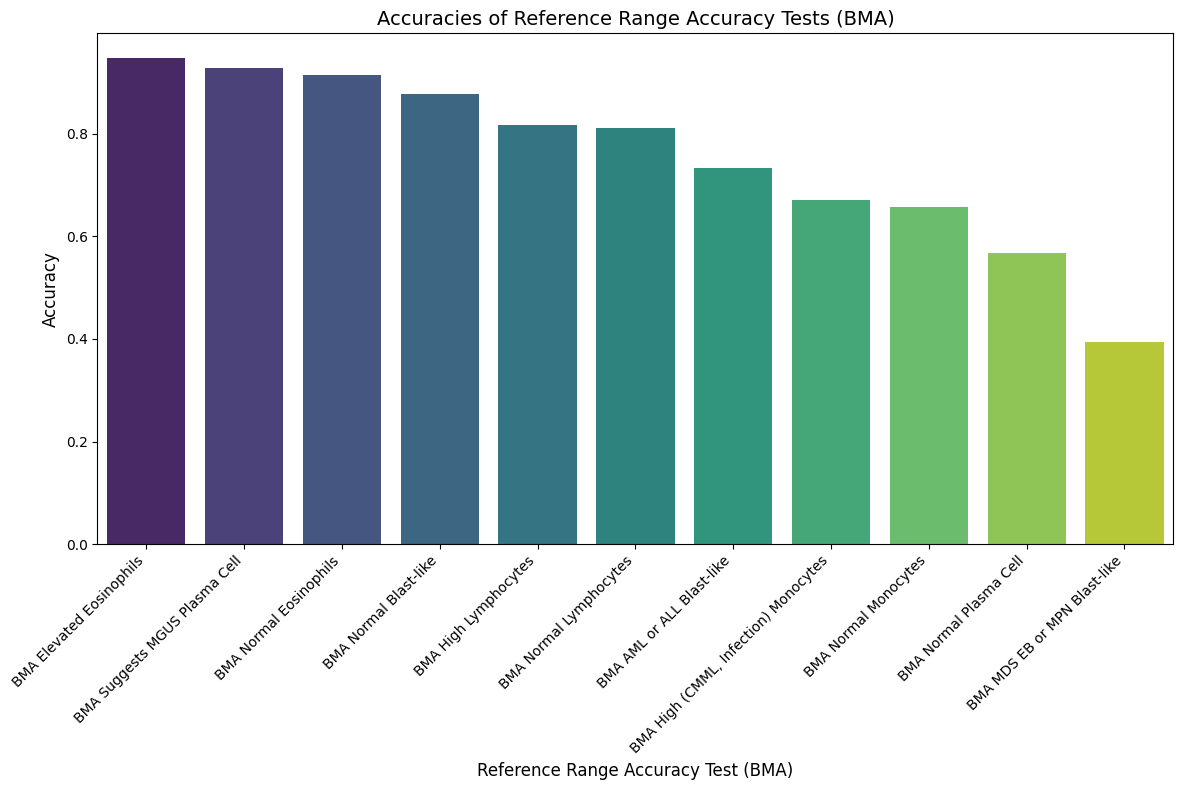

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy for each BMA test case
accuracies = {
    test_name: (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    for test_name, conf_matrix in confusion_matrices.items()
    if "BMA" in test_name and conf_matrix.sum() > 0
}

# Convert accuracies to a DataFrame for plotting
accuracy_df = pd.DataFrame(
    accuracies.items(), columns=["Reference Range Accuracy Test (BMA)", "Accuracy"]
)
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=accuracy_df,
    x="Reference Range Accuracy Test (BMA)",
    y="Accuracy",
    palette="viridis",
)

# Customize the plot
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xlabel("Reference Range Accuracy Test (BMA)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracies of Reference Range Accuracy Tests (BMA)", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

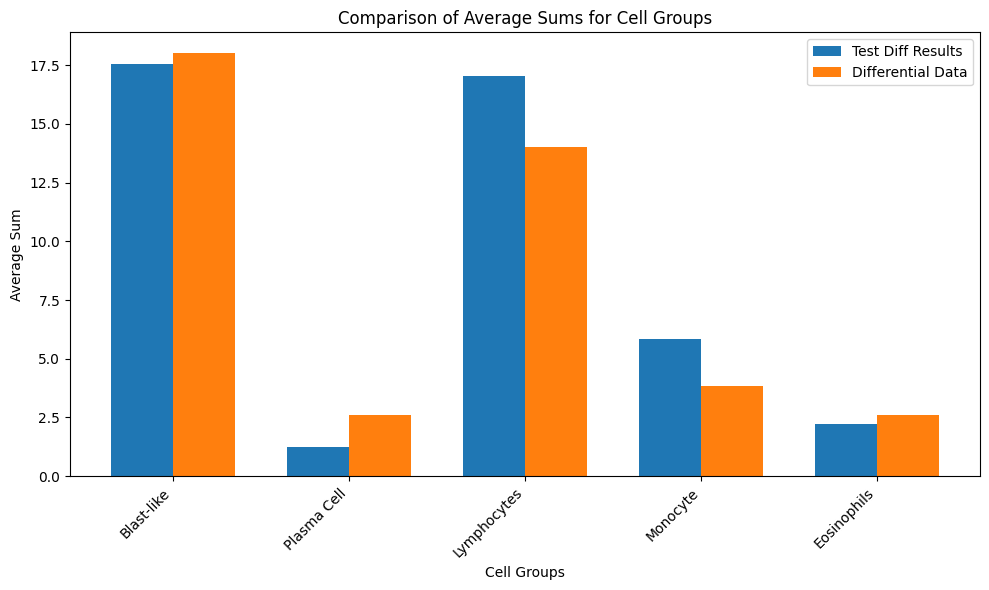

In [19]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the data
test_diff_results = pd.read_csv(
    "/Users/neo/Documents/MODS/LL-Eval/data/2024-10-10/test_diff_results.csv"
)
differential_data = pd.read_csv(
    "/Users/neo/Documents/MODS/LL-Eval/data/2024-10-10/differential_data_2024-10-10.csv"
)

# Load the cell_groups JSON
with open("/Users/neo/Documents/MODS/LL-Eval/cell_groups.json", "r") as f:
    cell_groups = json.load(f)

# Prepare lists for storing results
group_labels = []
test_diff_averages = []
differential_data_averages = []

# Iterate over each cell group to compute the required sums and averages
for group, classes in cell_groups.items():
    # Extract cell_classes and diff_classes
    cell_classes = classes["cell_classes"]
    diff_classes = classes["diff_classes"]

    # Compute the sum of the columns specified in cell_classes from test_diff_results
    test_diff_sum = test_diff_results[cell_classes].sum().sum()
    test_diff_average = test_diff_sum / len(test_diff_results)

    # multiple the sum by 100
    test_diff_average = test_diff_average * 100

    # Compute the sum of the columns specified in diff_classes from differential_data
    diff_data_sum = differential_data[diff_classes].sum().sum()
    diff_data_average = diff_data_sum / len(differential_data)

    # Store the results
    group_labels.append(group)
    test_diff_averages.append(test_diff_average)
    differential_data_averages.append(diff_data_average)

# Create the bar plot
x = np.arange(len(group_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, test_diff_averages, width, label="Test Diff Results")
bars2 = ax.bar(
    x + width / 2, differential_data_averages, width, label="Differential Data"
)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel("Cell Groups")
ax.set_ylabel("Average Sum")
ax.set_title("Comparison of Average Sums for Cell Groups")
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
# plt.show()